In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output

import seaborn as sns
sns.set_style('white')

In [2]:
import os
from tqdm import tqdm
from glob import glob
import pickle
from collections import defaultdict

import skimage
import numpy as np
import pandas as pd
import scipy
import numpy_indexed as npi

import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics

import cv2

In [3]:
import torch
from torch.utils.data.sampler import Sampler
import torch.nn.functional as F

import torchvision.models as models

In [4]:
import sys

sys.path.append('..')
import src.utils.dataset as ds
from src.utils.visualisation import *
from src.configs import config
from src.utils import learner as lrn
from src.utils import lr_finder as lrf
from src.utils import augmentations as augs
from src.utils import visualisation
from src.utils import rles

# from src.modules import wider_resnet

%load_ext autoreload
%autoreload 2
# # import losses
# # import metrics


In [5]:
CUDA_IDX = 0
torch.cuda.set_device(CUDA_IDX)

In [6]:
class FocalLoss(torch.nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()

In [7]:
import os


def create_dir(path):
    try:
        os.mkdir(path)
        print('Directory created: {}'.format(path))
    except:
        print('Directory exists: {}'.format(path))


def init_history(path):
        if os.path.isfile(path):
            return pickle.load(open(path, 'rb'))
        else:
            return defaultdict(list)


def format_predictions(results):
    predictions = np.concatenate([r['prediction'] for r in results])
#     predictions = torch.sigmoid(torch.tensor(predictions))
    labels = np.concatenate([r['label'] for r in results])
    loss = np.concatenate([r['loss'].reshape(1) for r in results])
    f1_score = measure_f1(predictions, labels)
    return {
        'predictions': predictions,
        'labels': labels,
        'loss': loss,
        'f1_score': f1_score,
    }

def prepare_data(datagen, nb_samples=config.PARAMS['NB_INFERS']):
    if isinstance(nb_samples, int):
        nb_samples = range(nb_samples)
    data = [datagen.dataset[i] for i in nb_samples]
    data = datagen.collate_fn(data)
    return data


def measure_f1(predictions, labels, threshs=.5):
    if isinstance(threshs, float):
        threshs = [threshs] * labels.shape[-1]
    return [
        sklearn.metrics.f1_score(labels[:, i], predictions[:, i] > threshs[i]) 
        for i, el in enumerate(label_names_list)
    ]


def format_history(history):
    return {
        key: [np.mean([el[key]]) for el in history] 
        for key in config.PARAMS['PLOT_KEYS']
    }


def plot_losses(formated_train, formated_valid):
    _, axes = plt.subplots(ncols=len(config.PARAMS['PLOT_KEYS']), figsize=(10 * len(config.PARAMS['PLOT_KEYS']), 6))

    for i, key in enumerate(config.PARAMS['PLOT_KEYS']):
        axes[i].plot(formated_valid[key], label='{} valid'.format(key), alpha=0.7, color='C{}'.format(i * 2))
        axes[i].plot(formated_train[key], label='{} trian'.format(key), alpha=0.7, color='C{}'.format(i * 2 + 1))

        axes[i].set_title(key)
        axes[i].legend()
        axes[i].grid()

    plt.show()

In [8]:
class Orchestrate:
    def __init__(self, learner, checkpoints_pth,
                 lr_scheduler=None,
                 fold=0, hard_negative_miner=None,
                 verbose=True, traced_key='loss', augmentations=None):
        self.learner = learner
        self.hard_negative_miner = hard_negative_miner
        self.verbose = verbose
        self.lr_scheduler = lr_scheduler
        self.traced_key = traced_key

        create_dir(checkpoints_pth)
        self.path = os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_{}'.format(fold, '{}'))
        self.history = init_history(self.path.format('loss'))
        self.last_epoch = len(self.history['train_losses'])

        folds = ds.get_folds(config.PARAMS['NB_FOLDS'], config.PARAMS['SEED'])
        train_dataset, valid_dataset = ds.get_datasets(folds, fold, augmentations=augmentations)
        train_datagen, valid_datagen = ds.get_datagens(train_dataset, valid_dataset)
        self.train_datagen, self.valid_datagen = train_datagen, valid_datagen

    def __call__(self, nb_epochs=config.PARAMS['NB_EPOCHS']):
        for epoch_i in range(self.last_epoch, nb_epochs):
            if hasattr(self.lr_scheduler, 'step'):
                self.lr_scheduler.step()
            self.learner.freeze_encoder(unfreeze=(epoch_i >= config.PARAMS['NB_FREEZED_EPOCHS']))

            self.iteration(epoch_i)
            self.checkpoint(epoch_i)

    def iteration(self, epoch_i):
        meters = self.learner.train_on_epoch(
            self.train_datagen, 
            hard_negative_miner=self.hard_negative_miner,
            lr_scheduler=self.lr_scheduler
        )
        meters = format_predictions(meters)
        self.history['train_losses'].append(meters)

        meters = self.learner.validate(self.valid_datagen)
        meters = format_predictions(meters)
        self.history['valid_losses'].append(meters)

        clear_output(wait=True)

    def checkpoint(self, epoch_i):
        if self.verbose:
            plt.figure(figsize=(15,10))
            sns.barplot(y=label_names_list, x=self.history['valid_losses'][-1]['f1_score']);
            plt.show()
            
            formated_train = format_history(self.history['train_losses'])
            formated_valid = format_history(self.history['valid_losses'])
            plot_losses(formated_train, formated_valid)
            data = prepare_data(self.valid_datagen, config.PARAMS['NB_INFERS'])
            self.learner.infer_on_data(data)

        trace = formated_valid[self.traced_key]
        if trace[-1] >= max(trace):
            state_dict = self.learner.save(self.path.format('best'))
        if epoch_i == (config.PARAMS['NB_EPOCHS'] - 1):
            state_dict = self.learner.save(self.path.format(epoch_i))

        pickle.dump(self.history, open(self.path.format('loss'), 'wb'))


In [9]:
loss = FocalLoss(gamma=2)
augmentations = augs.Augmentation(side=config.PARAMS['SIDE'], simplex_noise=config.PARAMS['SIMPLEX_NOISE'])

# SIDE == 384

In [10]:
from skimage.morphology import watershed
import scipy.ndimage as ndimage
from PIL import Image, ImagePalette

from torch.nn import functional as F
from torchvision.transforms import ToTensor, Normalize, Compose
import torch

import tifffile as tiff
import cv2
import random
from pathlib import Path

In [11]:
random.seed(42)
NUCLEI_PALETTE = ImagePalette.random()
random.seed()

In [12]:
# rcParams['figure.figsize'] = 15, 15

In [13]:
from src.modules.bn import ABN, InPlaceABN
from src.models.ternausnet_v2 import TernausNetV2

/home/vessemer/anaconda3/envs/cxr/lib/python3.6/site-packages/torch/utils/cpp_extension.py:118: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your compiler (c++) may be ABI-incompatible with PyTorch!
Please use a compiler that is ABI-compatible with GCC 4.9 and above.
See https://gcc.gnu.org/onlinedocs/libstdc++/manual/abi.html.

See https://gist.github.com/goldsborough/d466f43e8ffc948ff92de7486c5216d6
for instructions on how to install GCC 4.9 or higher.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

                              !! WARNING !!

  warnings.warn(ABI_INCOMPATIBILITY_WARNING.format(compiler))


In [14]:
def pad(img, pad_size=32):
    """
    Load image from a given path and pad it on the sides, so that eash side is divisible by 32 (network requirement)
    if pad = True:
        returns image as numpy.array, tuple with padding in pixels as(x_min_pad, y_min_pad, x_max_pad, y_max_pad)
    else:
        returns image as numpy.array
    """

    if pad_size == 0:
        return img

    height, width = img.shape[:2]

    if height % pad_size == 0:
        y_min_pad = 0
        y_max_pad = 0
    else:
        y_pad = pad_size - height % pad_size
        y_min_pad = int(y_pad / 2)
        y_max_pad = y_pad - y_min_pad

    if width % pad_size == 0:
        x_min_pad = 0
        x_max_pad = 0
    else:
        x_pad = pad_size - width % pad_size
        x_min_pad = int(x_pad / 2)
        x_max_pad = x_pad - x_min_pad

    img = cv2.copyMakeBorder(img, y_min_pad, y_max_pad, x_min_pad, x_max_pad, cv2.BORDER_REFLECT_101)

    return img, (x_min_pad, y_min_pad, x_max_pad, y_max_pad)

In [15]:
def unpad(img, pads):
    """
    img: numpy array of the shape (height, width)
    pads: (x_min_pad, y_min_pad, x_max_pad, y_max_pad)
    @return padded image
    """
    (x_min_pad, y_min_pad, x_max_pad, y_max_pad) = pads
    height, width = img.shape[:2]

    return img[y_min_pad:height - y_max_pad, x_min_pad:width - x_max_pad]

In [16]:
def minmax(img):
    out = np.zeros_like(img).astype(np.float32)
    if img.sum() == 0:
        return bands

    for i in range(img.shape[2]):
        c = img[:, :, i].min()
        d = img[:, :, i].max()

        t = (img[:, :, i] - c) / (d - c)
        out[:, :, i] = t
    return out.astype(np.float32)


def load_image(file_name_rgb, file_name_tif=None):    
    rgb = cv2.imread(str(file_name_rgb))[..., ::-1]
    rgb = minmax(rgb)
    
    return rgb * (2 ** 8 - 1)


def label_watershed(before, after, component_size=20):
    markers = ndimage.label(after)[0]

    labels = watershed(-before, markers, mask=before, connectivity=8)
    unique, counts = np.unique(labels, return_counts=True)

    for (k, v) in dict(zip(unique, counts)).items():
        if v < component_size:
            labels[labels == k] = 0
    return labels

In [17]:
def get_model(model_path, num_input_channels=3):
    model = TernausNetV2(num_classes=2, num_input_channels=num_input_channels)

    state = torch.load(model_path)
    state['model']['module.conv1.conv1.weight'] = state['model']['module.conv1.conv1.weight'][:, :num_input_channels]
    state = {key.replace('module.', '').replace('bn.', ''): value for key, value in state['model'].items()}

    model.load_state_dict(state)
    model.eval()

    if torch.cuda.is_available():
        model.cuda()
    return model

In [18]:
def get_model(model_path, num_input_channels=3):
    model = TernausNetV2(num_classes=2, num_input_channels=num_input_channels)

    state = torch.load(model_path)
    state['model']['module.conv1.conv1.weight'] = state['model']['module.conv1.conv1.weight'][:, :num_input_channels]
    state = {key.replace('module.', '').replace('bn.', ''): value for key, value in state['model'].items()}

    model.load_state_dict(state)
    model.eval()

    return model

In [19]:
import os


def create_dir(path):
    try:
        os.mkdir(path)
        print('Directory created: {}'.format(path))
    except:
        print('Directory exists: {}'.format(path))


def init_history(path):
        if os.path.isfile(path):
            return pickle.load(open(path, 'rb'))
        else:
            return defaultdict(list)


def format_predictions(results):
    loss = np.concatenate([r['loss'].reshape(1) for r in results])
    return {
        'loss': loss,
    }

def format_history(history):
    return {
        key: [np.mean([el[key]]) for el in history] 
        for key in config.PARAMS['PLOT_KEYS']
    }


def plot_losses(formated_train, formated_valid):
    _, axes = plt.subplots(ncols=max(len(config.PARAMS['PLOT_KEYS']), 2), figsize=(10 * len(config.PARAMS['PLOT_KEYS']), 6))

    for i, key in enumerate(config.PARAMS['PLOT_KEYS']):
        axes[i].plot(formated_valid[key], label='{} valid'.format(key), alpha=0.7, color='C{}'.format(i * 2))
        axes[i].plot(formated_train[key], label='{} trian'.format(key), alpha=0.7, color='C{}'.format(i * 2 + 1))

        axes[i].set_title(key)
        axes[i].legend()
        axes[i].grid()

    plt.show()

In [20]:
class Orchestrate:
    def __init__(self, learner, checkpoints_pth,
                 lr_scheduler=None, prefix='',
                 fold=0, hard_negative_miner=None,
                 verbose=True, traced_key='loss', augmentations=None):
        self.learner = learner
        self.hard_negative_miner = hard_negative_miner
        self.verbose = verbose
        self.lr_scheduler = lr_scheduler
        self.traced_key = traced_key

        create_dir(checkpoints_pth)
        self.path = os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_{}'.format(fold, '{}'))
        self.history = init_history(self.path.format('loss'))
        self.last_epoch = len(self.history['train_losses'])

        folds = ds.get_folds(config.PARAMS['NB_FOLDS'], config.PARAMS['SEED'])
        train_dataset, valid_dataset = ds.get_datasets(folds, fold, prefix=prefix, augmentations=augmentations)
        train_datagen, valid_datagen = ds.get_datagens(train_dataset, valid_dataset, batch_size=config.PARAMS['BATCH_SIZE'])
        self.train_datagen, self.valid_datagen = train_datagen, valid_datagen

    def __call__(self, nb_epochs=config.PARAMS['NB_EPOCHS']):
        for epoch_i in range(self.last_epoch, nb_epochs):
            if hasattr(self.lr_scheduler, 'step'):
                self.lr_scheduler.step()
            if hasattr(self.learner, 'freeze_encoder'):
                self.learner.freeze_encoder(unfreeze=(epoch_i >= config.PARAMS['NB_FREEZED_EPOCHS']))

            self.iteration(epoch_i)
            self.checkpoint(epoch_i, nb_epochs)

    def iteration(self, epoch_i):
        meters = self.learner.train_on_epoch(
            self.train_datagen, 
            hard_negative_miner=self.hard_negative_miner,
            lr_scheduler=self.lr_scheduler
        )
        meters = format_predictions(meters)
        self.history['train_losses'].append(meters)

        meters = self.learner.validate(self.valid_datagen)
        meters = format_predictions(meters)
        self.history['valid_losses'].append(meters)

        clear_output(wait=True)

    def checkpoint(self, epoch_i, nb_epochs=-1):
        if self.verbose:
            train = format_history(orchestrater.history['train_losses'])
            valid = format_history(orchestrater.history['valid_losses'])
            plot_losses(train, valid)
            learner.infer_on_data(self.valid_datagen.dataset[2])
            learner.infer_on_data(self.valid_datagen.dataset[0])

        trace = valid[self.traced_key]
        if trace[-1] <= min(trace):
            state_dict = self.learner.save(self.path.format('best'))
        if epoch_i == (nb_epochs - 1):
            state_dict = self.learner.save(self.path.format(epoch_i))

        pickle.dump(self.history, open(self.path.format('loss'), 'wb'))


In [21]:
from src.utils import losses


loss = losses.BCEDiceJaccardLoss(
    weights={
        'bce': .5,
        'jacc': .5,
    },
)

augmentations = augs.Augmentation(side=config.PARAMS['SIDE'], simplex_noise=config.PARAMS['SIMPLEX_NOISE'])

In [22]:
checkpoints_pth = '../data/models/densnet121_side_512/'

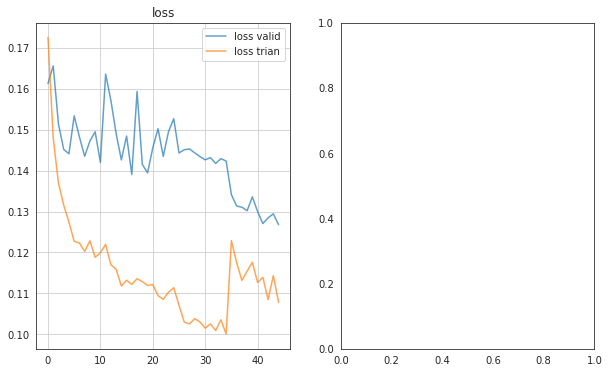

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


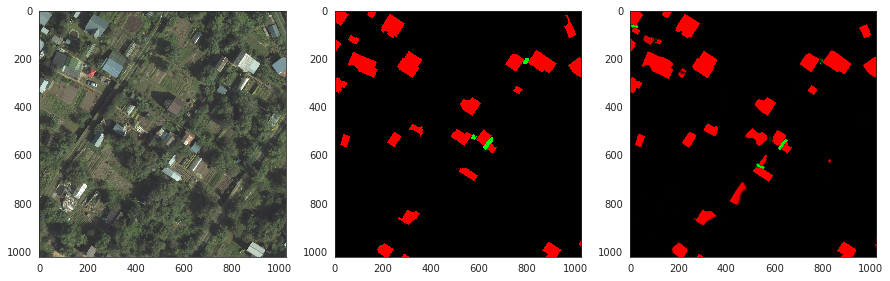

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


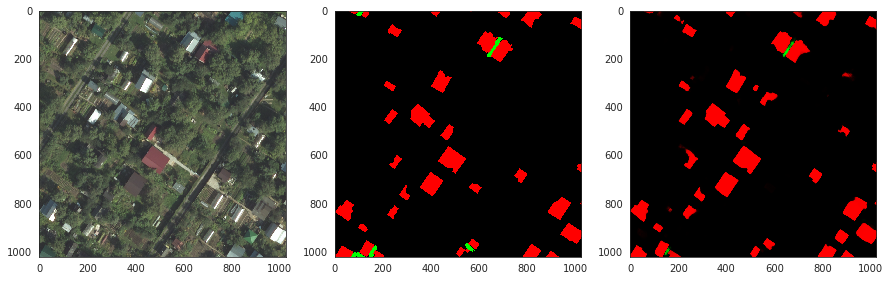

Saved in ../data/models/densnet121_side_512/fold_0_checkpoint.epoch_best:


In [22]:
checkpoints_pth = '../data/models/densnet121_side_512/'
fold = 0

model = get_model('../data/models/deepglobe_wide_resnext/deepglobe_buildings.pt')
model = lrn.get_model(model, devices=config.PARAMS['CUDA_DEVICES'])

opt = torch.optim.Adam(model.parameters(), lr=1e-4)
learner = lrn.Learner(model=model, opt=opt, loss=loss)
augmentations = augs.Augmentation(side=448, simplex_noise=config.PARAMS['SIMPLEX_NOISE'])
config.PARAMS['BATCH_SIZE'] = 12

orchestrater = Orchestrate(
    learner, checkpoints_pth=checkpoints_pth, fold=fold, lr_scheduler=None, 
    hard_negative_miner=None, verbose=True, traced_key='loss', 
    augmentations=augmentations, prefix='_shrinked'
)

orchestrater(nb_epochs=25)

for param_group in opt.param_groups:
    param_group['lr'] = 1e-5
    param_group['initial_lr'] = 1e-5


orchestrater = Orchestrate(
    learner, checkpoints_pth=checkpoints_pth, fold=fold, lr_scheduler=None, 
    hard_negative_miner=None, verbose=True, traced_key='loss', 
    augmentations=augmentations, prefix='_shrinked'
)

orchestrater(nb_epochs=35)

lr_scheduler = lrf.Pilo(
    opt, min_lr=5e-6, max_lr=1e-5, 
    coeff=.85, steps_per_epoch=200, 
)

augmentations = augs.Augmentation(side=672, simplex_noise=config.PARAMS['SIMPLEX_NOISE'])
config.PARAMS['BATCH_SIZE'] = 4

orchestrater = Orchestrate(
    learner, checkpoints_pth=checkpoints_pth, fold=fold, lr_scheduler=None, 
    hard_negative_miner=None, verbose=True, traced_key='loss', 
    augmentations=augmentations, prefix='_orig'
)

orchestrater(nb_epochs=45)

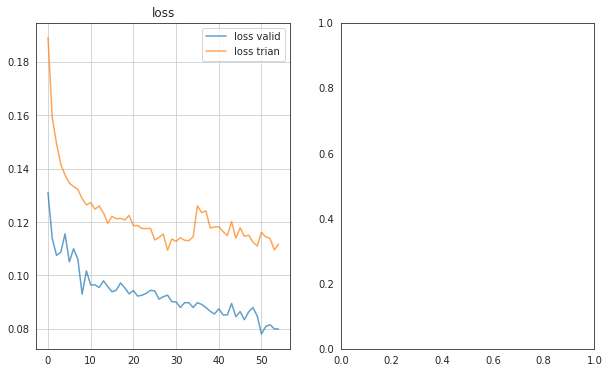

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


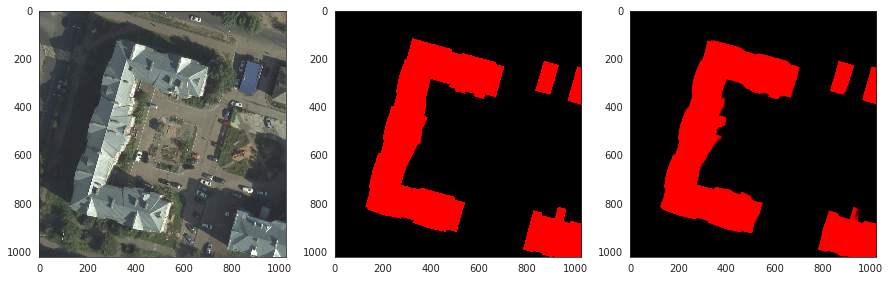

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


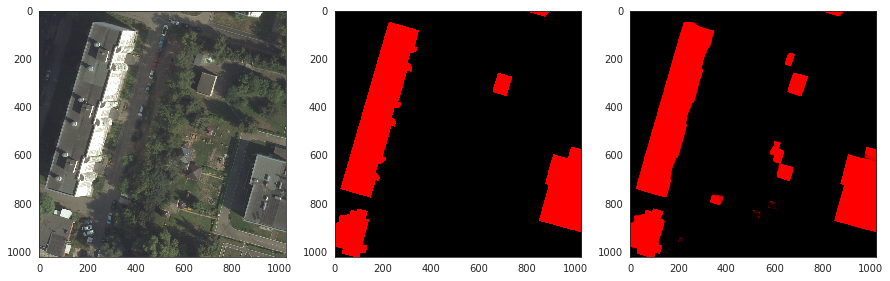

In [22]:
checkpoints_pth = '../data/models/densnet121_side_512/'
fold = 1

model = get_model('../data/models/deepglobe_wide_resnext/deepglobe_buildings.pt')
model = lrn.get_model(model, devices=config.PARAMS['CUDA_DEVICES'])

opt = torch.optim.Adam(model.parameters(), lr=5e-5)
learner = lrn.Learner(model=model, opt=opt, loss=loss)
augmentations = augs.Augmentation(side=448, simplex_noise=config.PARAMS['SIMPLEX_NOISE'])
config.PARAMS['BATCH_SIZE'] = 12

orchestrater = Orchestrate(
    learner, checkpoints_pth=checkpoints_pth, fold=fold, lr_scheduler=None, 
    hard_negative_miner=None, verbose=True, traced_key='loss', 
    augmentations=augmentations, prefix='_shrinked'
)

orchestrater(nb_epochs=25)

for param_group in opt.param_groups:
    param_group['lr'] = 1e-5
    param_group['initial_lr'] = 1e-5


orchestrater = Orchestrate(
    learner, checkpoints_pth=checkpoints_pth, fold=fold, lr_scheduler=None, 
    hard_negative_miner=None, verbose=True, traced_key='loss', 
    augmentations=augmentations, prefix='_shrinked'
)

orchestrater(nb_epochs=35)

lr_scheduler = lrf.Pilo(
    opt, min_lr=5e-6, max_lr=1e-5, 
    coeff=.85, steps_per_epoch=200, 
)

augmentations = augs.Augmentation(side=672, simplex_noise=config.PARAMS['SIMPLEX_NOISE'])
config.PARAMS['BATCH_SIZE'] = 4

orchestrater = Orchestrate(
    learner, checkpoints_pth=checkpoints_pth, fold=fold, lr_scheduler=None, 
    hard_negative_miner=None, verbose=True, traced_key='loss', 
    augmentations=augmentations, prefix='_orig'
)

orchestrater(nb_epochs=55)

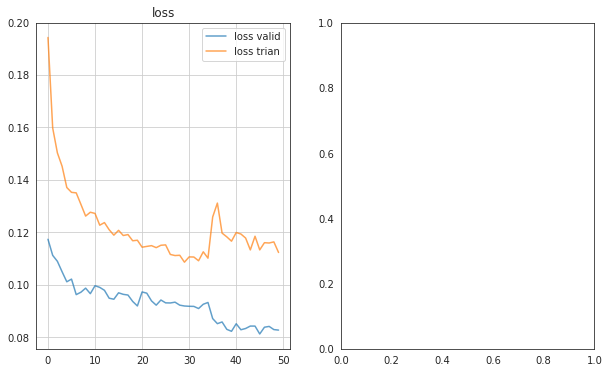

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


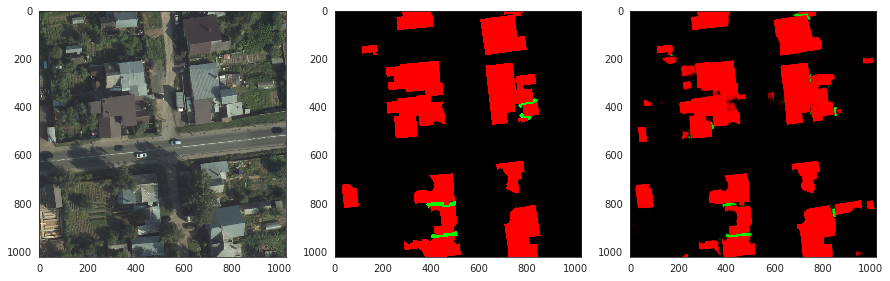

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


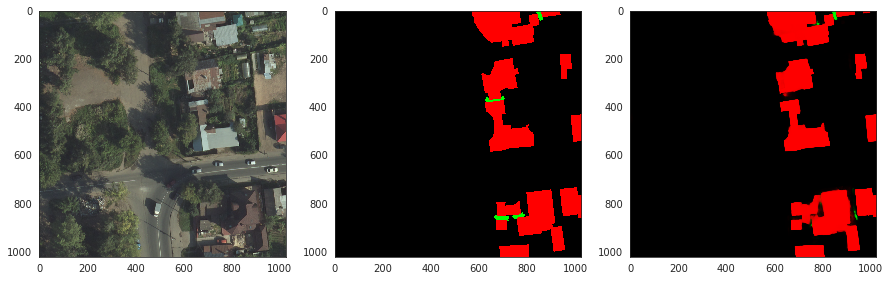

 13%|█▎        | 38/293 [00:48<05:27,  1.29s/it]

In [ ]:
checkpoints_pth = '../data/models/densnet121_side_512/'
fold = 2

model = get_model('../data/models/deepglobe_wide_resnext/deepglobe_buildings.pt')
model = lrn.get_model(model, devices=config.PARAMS['CUDA_DEVICES'])

opt = torch.optim.Adam(model.parameters(), lr=5e-5)
learner = lrn.Learner(model=model, opt=opt, loss=loss)
augmentations = augs.Augmentation(side=448, simplex_noise=config.PARAMS['SIMPLEX_NOISE'])
config.PARAMS['BATCH_SIZE'] = 12

orchestrater = Orchestrate(
    learner, checkpoints_pth=checkpoints_pth, fold=fold, lr_scheduler=None, 
    hard_negative_miner=None, verbose=True, traced_key='loss', 
    augmentations=augmentations, prefix='_shrinked'
)

orchestrater(nb_epochs=25)

for param_group in opt.param_groups:
    param_group['lr'] = 1e-5
    param_group['initial_lr'] = 1e-5


orchestrater = Orchestrate(
    learner, checkpoints_pth=checkpoints_pth, fold=fold, lr_scheduler=None, 
    hard_negative_miner=None, verbose=True, traced_key='loss', 
    augmentations=augmentations, prefix='_shrinked'
)

orchestrater(nb_epochs=35)

lr_scheduler = lrf.Pilo(
    opt, min_lr=5e-6, max_lr=1e-5, 
    coeff=.85, steps_per_epoch=200, 
)

augmentations = augs.Augmentation(side=672, simplex_noise=config.PARAMS['SIMPLEX_NOISE'])
config.PARAMS['BATCH_SIZE'] = 4

orchestrater = Orchestrate(
    learner, checkpoints_pth=checkpoints_pth, fold=fold, lr_scheduler=None, 
    hard_negative_miner=None, verbose=True, traced_key='loss', 
    augmentations=augmentations, prefix='_orig'
)

orchestrater(nb_epochs=55)

In [ ]:
fold = 2
model = get_model('../data/models/deepglobe_wide_resnext/deepglobe_buildings.pt')
model = lrn.get_model(model, checkpoint='../data/models/densnet121_side_512/fold_{}_checkpoint.epoch_best'.format(fold), devices=config.PARAMS['CUDA_DEVICES'])
opt = torch.optim.Adam(model.parameters(), lr=5e-5)
learner = lrn.Learner(model=model, opt=opt, loss=loss)
augmentations = augs.Augmentation(side=672, simplex_noise=config.PARAMS['SIMPLEX_NOISE'])

coeff = .85 ** 29

lr_scheduler = lrf.Pilo(
    opt, min_lr=coeff * 5e-6, max_lr=coeff * 1e-5, 
    coeff=.85, steps_per_epoch=100, 
)

augmentations = augs.Augmentation(side=672, simplex_noise=config.PARAMS['SIMPLEX_NOISE'])
config.PARAMS['BATCH_SIZE'] = 4

orchestrater = Orchestrate(
    learner, checkpoints_pth=checkpoints_pth, fold=fold, lr_scheduler=None, 
    hard_negative_miner=None, verbose=True, traced_key='loss', 
    augmentations=augmentations, prefix='_orig'
)

orchestrater(nb_epochs=60)

# Inference

In [23]:
fold = 1
model = get_model('../data/models/deepglobe_wide_resnext/deepglobe_buildings.pt')
model = lrn.get_model(model, checkpoint='../data/models/densnet121_side_512/fold_{}_checkpoint.epoch_best'.format(fold), devices=config.PARAMS['CUDA_DEVICES'])

Overlapped keys: 179


In [24]:
MEAN = [0.31611712, 0.30189482, 0.20617615]
STD = [0.06082994, 0.06330029, 0.0722641]

img_transform = Compose([
    ToTensor(),
    Normalize(mean=MEAN, std=STD)
])

In [25]:
side = 672
step = side // 2
template = '../data/TEST_FINAL/*{}'

In [26]:
def load_image(file_name_rgb, file_name_tif=None):    
    return cv2.imread(str(file_name_rgb))[..., ::-1]

In [27]:
def _rotate_mirror_undo(im_mirrs):
    """
    merges a list of 8 np arrays (images) of shape (x, y, nb_channels) generated
    from the `_rotate_mirror_do` function. Each images might have changed and
    merging them implies to rotated them back in order and average things out.
    It is the D_4 (D4) Dihedral group:
    https://en.wikipedia.org/wiki/Dihedral_group
    """
    origs = []
    origs.append(np.array(im_mirrs[0]))
    origs.append(np.rot90(np.array(im_mirrs[1]), axes=(1, 2), k=3))
    origs.append(np.rot90(np.array(im_mirrs[2]), axes=(1, 2), k=2))
    origs.append(np.rot90(np.array(im_mirrs[3]), axes=(1, 2), k=1))
    origs.append(np.array(im_mirrs[4])[:, :, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[5]), axes=(1, 2), k=3)[:, :, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[6]), axes=(1, 2), k=2)[:, :, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[7]), axes=(1, 2), k=1)[:, :, ::-1])
    return np.mean(origs, axis=0)

In [28]:
postfix = '.png'
paths = glob(template.format(postfix))

main_frames = list()
for path in tqdm(paths):
    with torch.no_grad():
        image = load_image(path)
        shape = np.array(image.shape[:2])[::-1] // 2
    #     image = cv2.resize(image, tuple(shape.tolist()))

        main_frame = np.zeros((2, ) + image.shape[:2])
        main_frame_counter = np.zeros(image.shape[:2])

        shape = np.array(image.shape[:2])
        nb_crops = np.ceil((shape - side) / step).astype(np.int)
        xs = np.linspace(0, shape[0] - side, num=nb_crops[0]).astype(np.int)
        ys = np.linspace(0, shape[1] - side, num=nb_crops[1]).astype(np.int)
        for i, xi in tqdm(enumerate(xs)):
            for j, yi in enumerate(ys):
                img = image[xi: xi + side, yi: yi + side]
                # Network contains 5 maxpool layers => input should be divisible by 2**5 = 32 => we pad input image and mask
                img, pads = pad(img)
                img = torch.unsqueeze(img_transform(img), dim=0)
                img = augs._rotate_mirror_do(img.numpy())

                img = torch.tensor(img)
                img = torch.autograd.Variable(img).cuda()

                prediction = torch.sigmoid(model(img)).data.cpu().numpy()
                prediction = _rotate_mirror_undo(prediction)
                prediction = unpad(prediction, pads)

                main_frame[:, xi: xi + side, yi: yi + side] += prediction
                main_frame_counter[xi: xi + side, yi: yi + side] += 1

        main_frame_counter[np.logical_not(main_frame_counter)] = 1
        main_frame = main_frame / main_frame_counter[np.newaxis]
        main_frames.append(main_frame)

  0%|          | 0/3 [00:00<?, ?it/s]
0it [00:00, ?it/s]/home/vessemer/anaconda3/envs/cxr/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")

1it [00:13, 13.09s/it]
2it [00:23, 11.70s/it]
3it [00:33, 11.27s/it]
4it [00:44, 11.05s/it]
5it [00:54, 10.94s/it]
6it [01:07, 11.24s/it]
7it [01:18, 11.16s/it]
8it [01:30, 11.34s/it]
9it [01:43, 11.47s/it]
10it [01:56, 11.61s/it]
11it [02:07, 11.61s/it]
12it [02:20, 11.70s/it]
13it [02:31, 11.62s/it]
14it [02:43, 11.71s/it]
15it [02:55, 11.68s/it]
16it [03:06, 11.64s/it]
17it [03:19, 11.72s/it]
18it [03:30, 11.68s/it]
19it [03:42, 11.73s/it]
20it [03:55, 11.77s/it]
21it [04:07, 11.77s/it]
22it [04:19, 11.79s/it]
 33%|███▎      | 1/3 [04:20<08:40, 260.46s/it]
0it [00:00, ?it/s]
1it [00:13, 13.29s/it]
2it [00:24, 12.11s/it]
3it [00:35, 11.78s/it]
4it [00:48, 12.14s/it]


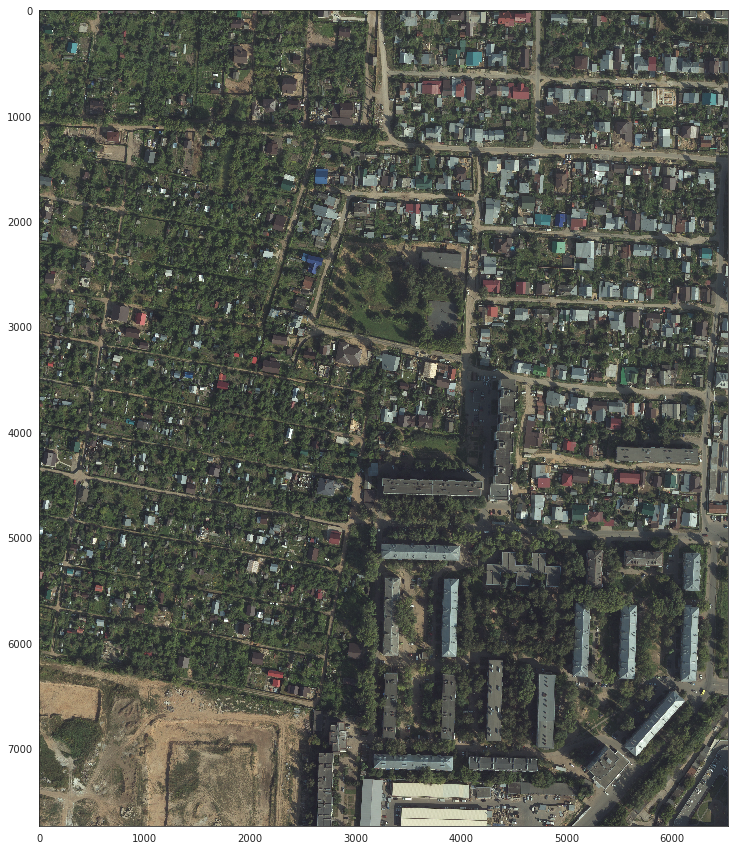

In [29]:
plt.figure(figsize=(15, 15))
plt.imshow(image[:, :, :3].astype(np.uint8))

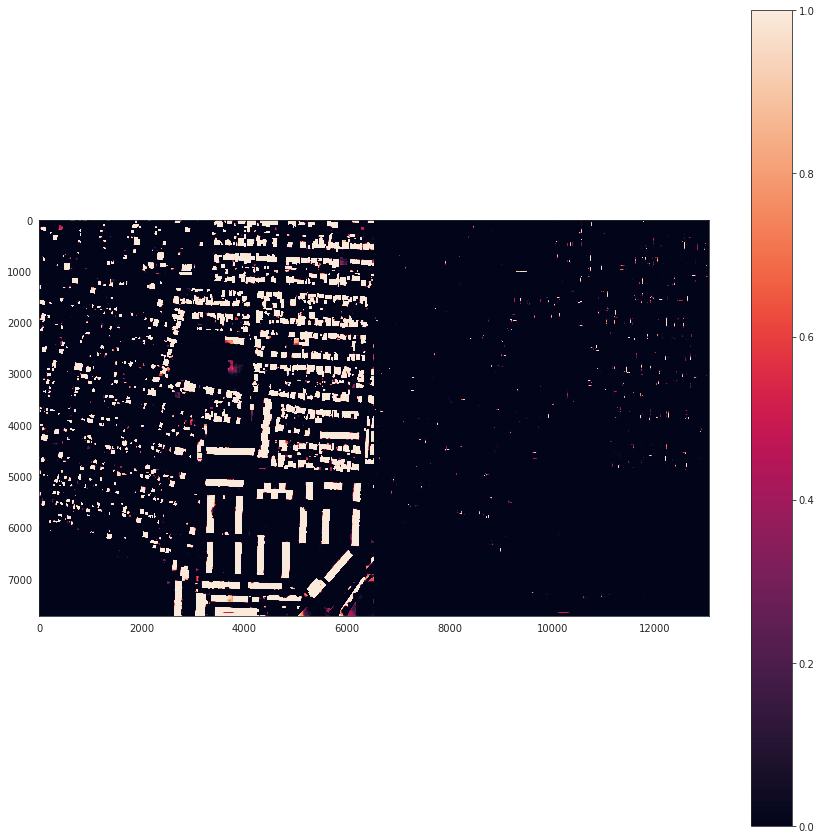

In [30]:
# left mask, right touching areas
plt.figure(figsize=(15, 15))
a = plt.imshow(np.hstack([main_frame[0], main_frame[1]]))
plt.colorbar(a)

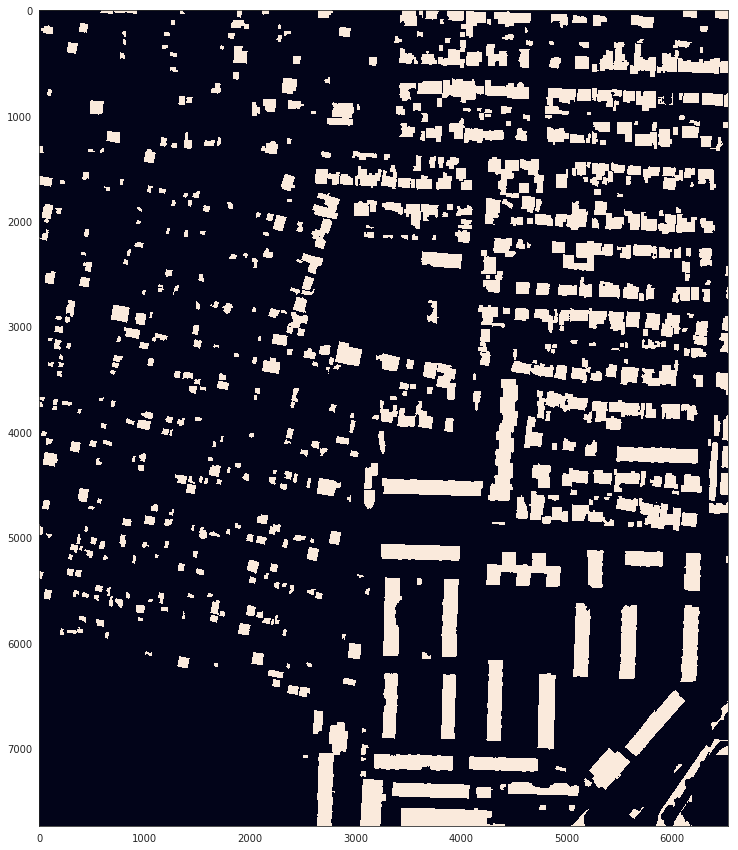

In [35]:
# left mask, right touching areas
plt.figure(figsize=(15, 15))
plt.imshow(labels > 0)

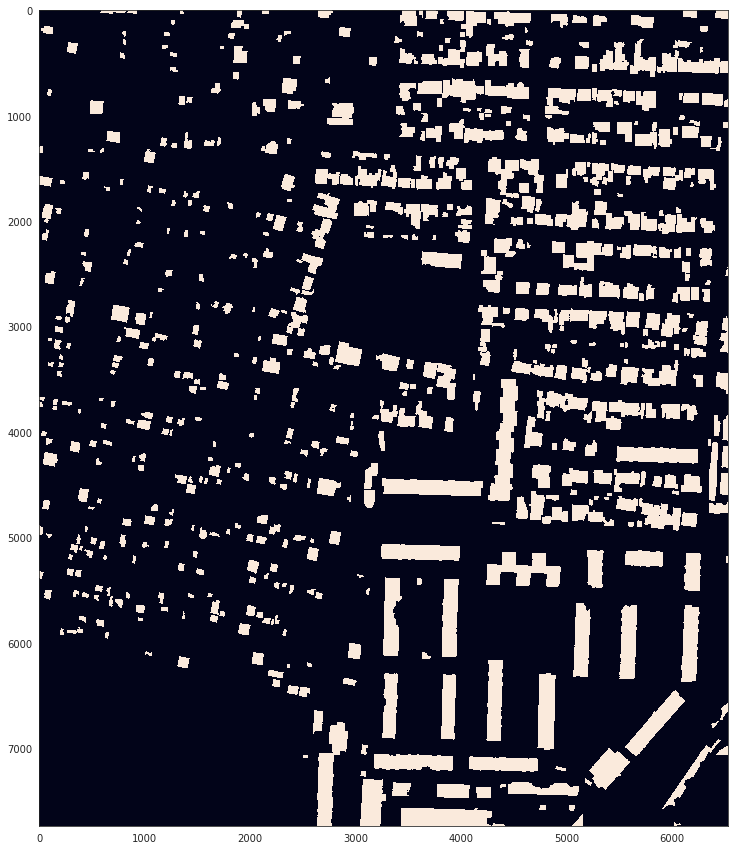

In [60]:
# left mask, right touching areas
plt.figure(figsize=(15, 15))
plt.imshow(labels > 0)

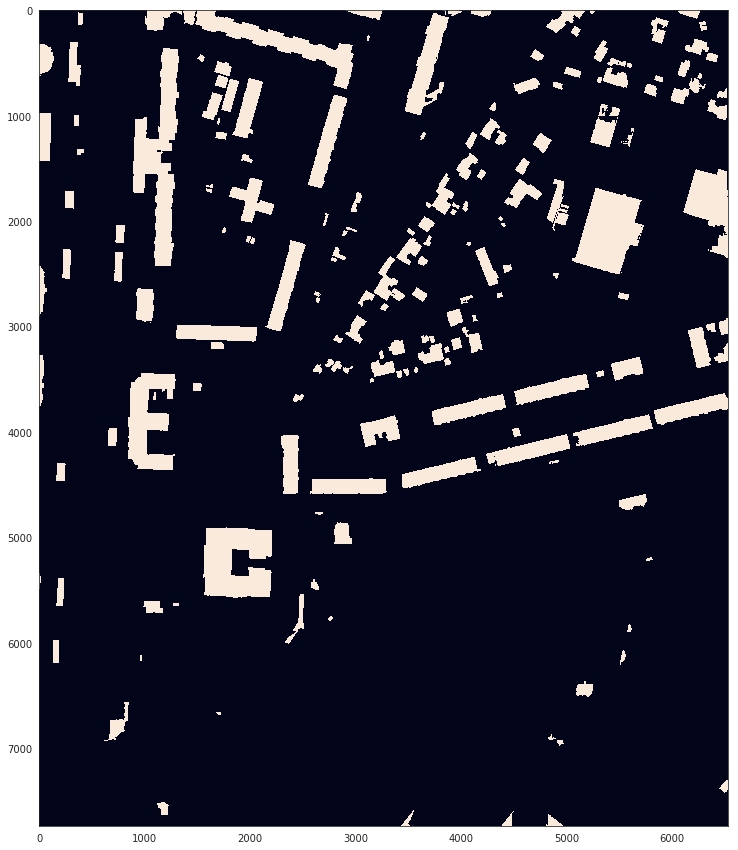

In [33]:
# left mask, right touching areas
plt.figure(figsize=(15, 15))
plt.imshow(labels > 0)

In [34]:
rle_preds_list = list()
for i, main_frame in tqdm(enumerate(main_frames)):
    mask = (main_frame[0] > 0.3).astype(np.uint8)
    contour = (main_frame[1])

    seed = ((mask * (1 - contour)) > 0.8).astype(np.uint8)
    labels = label_watershed(mask, seed)
#     drops = np.where(np.bincount(labels.flatten()) < 1190.47333333)[0]
#     for drop in tqdm(drops):
#         labels[labels == drop] = 0
    rle_preds_list.append(rles.multi_rle_encode(labels))



0it [00:00, ?it/s]/home/vessemer/anaconda3/envs/cxr/lib/python3.6/site-packages/skimage/util/arraycrop.py:175: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = np.array(ar[slices], order=order, copy=True)


  0%|          | 0/212 [00:00<?, ?it/s]

  2%|▏         | 4/212 [00:00<00:06, 31.83it/s]

  3%|▎         | 6/212 [00:00<00:09, 20.62it/s]

  4%|▍         | 9/212 [00:00<00:08, 23.03it/s]

  6%|▌         | 12/212 [00:00<00:08, 24.12it/s]

  7%|▋         | 14/212 [00:00<00:10, 19.55it/s]

  8%|▊         | 17/212 [00:00<00:09, 20.22it/s]

  9%|▉         | 20/212 [00:00<00:09, 20.98it/s]

 11%|█         | 23/212 [00:01<00:09, 20.60it/s]

 12%|█▏        | 26/212 [00:01<00:08, 21.04it/s]

 14%|█▎        | 29/212 [00:01<00:08, 21.20it/s]

 15%|█▌        | 32

In [36]:
rle_preds_list_ = list()
for path, r in zip(paths, rle_preds_list):
    name = os.path.basename(path).replace('_image', '')
    r = [(name, v) for v in r]
    rle_preds_list_.extend(r)

In [37]:
# labels = cv2.resize(labels.astype(np.uint16), image.shape[:2][::-1])

In [38]:
columns = ["ImageId", "EncodedPixels"]

df = pd.DataFrame(rle_preds_list_, columns=columns)
df.to_csv('_simple_2.csv', index=False)

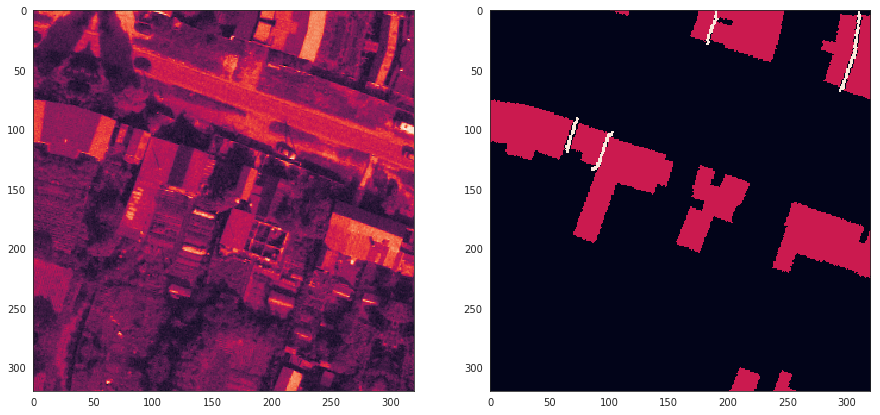

In [26]:
plt.figure(figsize=(15, 7))
plt.subplot(121)
plt.imshow(data['image'][0])
plt.subplot(122)
plt.imshow(data['mask'][0] + data['mask'][1] * 2)
plt.show()